In [1]:
import pandas as pd
import numpy as np
from nltk import RegexpTokenizer
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

import gensim

from sklearn.cluster import KMeans
from sklearn import metrics
import pylab as pl

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

import emoji
import regex as re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import pairwise_distances

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/natalie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data 

In [2]:
data = pd.read_csv('scrape/restaurant-data/cleaned_restaurant_reviews.csv', index_col=0).reset_index(drop=True)
data.head(2)

,url,name,neighbourhood,price,categories,review,user,date,cleaned_price,cleaned_categories,...,Western,Recommended,Sustainable,Novel,Desserts,Bites,Supper,Breakfast & Brunch,Halal,region
0,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nFish Ball Minced Meat Noodle\nFishball, meat...",Triffany Lim,21m ago,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
1,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nOrh lua\nThere are a couple of stores, but g...",Ally Tan,Jul 30 at 4:12pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East


### Review Text Cleaning
(to shift to eda code + run with translation)

In [3]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [4]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"didn\'t", "did not", phrase)
    phrase = re.sub(r"don\'t", "do not", phrase)
    phrase = re.sub(r"o\'clock", "clock", phrase)
    phrase = re.sub(r"couldn\'t", "could not", phrase)
    phrase = re.sub(r"that\'s", "that is", phrase)       
    phrase = re.sub(r"go-around", "go around", phrase)  
    # general
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    #phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [5]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [6]:
stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ['address', 'note', 'tel', 'website', 'open', 'burpple']
add_stopwords = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
    "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
    'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
    'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
    'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
    'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
    'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
    's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
    've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
    "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
    "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
    'won', "won't", 'wouldn', "wouldn't"])
add_stopwords_2 =  ['n','s','m','i','1','2','3','4','5','6','7','8','9','10','one','two',
    'it','in','ve','well','could','would','really','also','even',
    'alway','always','still','never','much','thing','yet',
    'said','asked','did','go','got','do','make','know','think','come','going',
    'put','went','seem','order','ordered','give','eat','make','get']

stopwords.extend(new_stopwords)
stopwords.extend(add_stopwords)
stopwords.extend(add_stopwords_2)

In [7]:
cleaned_review_list = []
count = 0

for review in data['review']:
    # lower case
    review = review.lower()

    # deemojize
    review = emoji.demojize(review)

    # remove headers
    review = ' '.join(review.split('\n')[2:])

    # remove location (pushpin or location:)
    review = review.split('round_pushpin')[0]
    review = review.split('location:')[0]

    # clean punctuation
    review = re.sub(r'[^\w\s]', '', review)

    # tokenize
    tokens = word_tokenize(review)

    # remove stopwords and URLs
    tokens = [word for word in tokens if word not in stopwords]
    tokens = [word for word in tokens if 'http' not in word]
    tokens = [word for word in tokens if 'www' not in word]

    # decontraction
    tokens = [decontracted(word) for word in tokens]

    ### to add in translation code... shld translate each token

    ### lemmatization
    # POS tagging
    tokens = [nltk.pos_tag([word]) for word in tokens]
            
    # lemmatization
    tokens = [lemmatizer.lemmatize(word[0][0], get_wordnet_pos(word[0][1])) 
        if get_wordnet_pos(word[0][1])!=None else lemmatizer.lemmatize(word[0][0]) for word in tokens]
    
    ### WORD FREQUENCY
    # modify count if POS tag is adjective
    # new_tokens = []
    # for token in tokens:
    #     new_tokens.append(token)
    #     word, pos = nltk.pos_tag([token])[0]
    #     if pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos == 'RB' or pos == 'RBR' or pos == 'RBS':  
    #         new_tokens.append(token) ### ADD 1 MORE WORD OCCURENCE
        #     if word in word_freq.keys():
        #         word_freq[word] += 2 ### TO CHANGE THIS PARAMETER (double frequency for adjectivies)
        #     else: 
        #         word_freq[word] = 2
        # else:
        #     if word in word_freq.keys():
        #         word_freq[word] += 1 
        #     else: 
        #         word_freq[word] = 1
        
    # concatenate tokens back
    cleaned_review = " ".join(tokens)
    cleaned_review_list.append(cleaned_review)

    if count%1000 == 0:
        print(count)
    count+=1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


In [8]:
# replace the old cleaned text
data['cleaned_text'] = cleaned_review_list

In [9]:
# concatenate all the reviews for each restaurant
restaurant_review_df = data[['url', 'cleaned_text']]
restaurant_review_df = restaurant_review_df.groupby(['url'], as_index = False).agg({'cleaned_text': ' '.join})
restaurant_review_df.head(5)

,url,cleaned_text
0,https://www.burpple.com/108-matcha-saro?bp_ref...,s850 strong matcha flavor soft serve topped wh...
1,https://www.burpple.com/136-hong-kong-street-f...,zhi char feast family love tze char lose count...
2,https://www.burpple.com/15-stamford?bp_ref=%2F...,four hand dinner chef alvin chef jay legendary...
3,https://www.burpple.com/25-degrees-singapore?b...,oh yesh loveeeee burger goooooood locate hotel...
4,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%...,signature firebird koreaninspired sandwich fry...


In [10]:
restaurant_characteristics_df = data.drop(['review', 'cleaned_text'], axis=1)
restaurant_characteristics_df = restaurant_characteristics_df.groupby(['url'], as_index = False).first()
restaurant_characteristics_df.head(2)

,url,name,neighbourhood,price,categories,user,date,cleaned_price,cleaned_categories,Healthy,...,Western,Recommended,Sustainable,Novel,Desserts,Bites,Supper,Breakfast & Brunch,Halal,region
0,https://www.burpple.com/108-matcha-saro?bp_ref...,108 Matcha Saro (Suntec City),Promenade,~$10/pax,"['Desserts', 'Ice Cream & Yoghurt', 'Japanese']",Stefanny Stefanny,Nov 8 at 3:09pm,10.0,"['Desserts', 'Desserts', 'Japanese']",0,...,0,0,0,0,1,0,0,0,0,South
1,https://www.burpple.com/136-hong-kong-street-f...,136 Hong Kong Street Fish Head Steamboat (Joo ...,Macpherson,~$15/pax,"['Rainy Day Comforts', 'Hawker Food', 'Hot Pot...",Spoons Of Delights,3h ago,15.0,"['Rainy Day Comforts', 'Local Delights', 'Chin...",0,...,0,0,0,0,0,0,0,0,0,East


In [11]:
restaurant_review_df = pd.merge(restaurant_review_df, restaurant_characteristics_df, on='url')

# Model

In [12]:
tokenizer = RegexpTokenizer(r'\w+')

def nlp_clean(data):
    new_data = []
    for d in data:
        new_str = d.lower()
        dlist = tokenizer.tokenize(new_str)
        new_data.append(dlist)
    return new_data

class LabeledLineSentence(object):
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
              yield gensim.models.doc2vec.TaggedDocument(doc, [self.labels_list[idx]])

In [13]:
# tokenize reviews
tokenized_reviews = nlp_clean(restaurant_review_df['cleaned_text'])

## Functions

In [14]:
# doc2vec
# word embeddings: calculate use frequency -> calculate cosine similarity -> group based on similar usage of words. (LDA just the first step)
# vector size 1000 == randomly selecting 1000

def doc2vec(tokenized_reviews, num_epochs): #, word_freq
    it = LabeledLineSentence(tokenized_reviews, restaurant_review_df['url']) # label reviews with the restaurant url
    model = gensim.models.Doc2Vec(vector_size=1000, min_count=5, alpha=0.025, min_alpha=0.025, seed=123) #### TO TUNE
    # model.build_vocab_from_freq(word_freq) #### TRY BUILD VOCAB FROM FREQ
    model.build_vocab(it)
    model.train(it, total_examples= model.corpus_count, epochs = num_epochs, start_alpha=0.002, end_alpha=-0.016)

    # print(model.corpus_count) ## check the corpus
    # print(len(model.docvecs)) # check doc2vec.

    ### plot the accuracy of each epoch so we can see if its over or under-fitted
    ### tweak learning rate and number of epochs
    return it, model

In [48]:
def optimise_epochs(tokenized_reviews, max_epoch):
    range_epochs = range(2,max_epoch+1)
    accuracy = []
    for num_epoch in range_epochs:
        it, model = doc2vec(tokenized_reviews, num_epoch)

        kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=100) ### ASSUME 5 clusters
        X = kmeans.fit(model.dv.vectors)
        silhouette_score_average = silhouette_score(model.dv.vectors, kmeans.predict(model.dv.vectors))
        accuracy.append(silhouette_score_average)

    plt.plot(list(range_epochs),accuracy)
    plt.title('Silhouette Score For Each Epoch')
    plt.show()

In [16]:
def plot_silhouette(tokenized_reviews):
    it, model = doc2vec(tokenized_reviews, 10)

    kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=100) ### ASSUME 5 clusters
    X = kmeans.fit(model.dv.vectors)
    silhouette_score_average = silhouette_score(model.dv.vectors, kmeans.predict(model.dv.vectors))
    return silhouette_score_average

In [17]:
def cosine_similarity_matrix(model):
    similarity_df = pd.DataFrame()

    for restaurant in it.labels_list:
        similarity_list = []
        for restaurant2 in it.labels_list:
            similarity_list.append(model.docvecs.similarity(restaurant, restaurant2))
        
        similarity_df[restaurant] = similarity_list

    similarity_df.index = list(it.labels_list)

    return similarity_df

In [18]:
def num_topics_elbow(model):
    # get optimal number of topics
    Sum_of_squared_distances = []
    K = range(1,15)
    for k in K:
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100)
        X = kmeans.fit(model.dv.vectors) ###using documnet vecter numbers. doctag_syn0 calls doc2vec that is trained earlier.
        Sum_of_squared_distances.append(kmeans.inertia_)

    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

def num_topics_silhouette(model, min_topic, max_topic): # min topic should be the first elbow observed
    ### K-means Accuracy (Silhouette Score) (assume minimum of 5 clusters)
    accuracy = []
    for k in range(min_topic,max_topic+1):
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100)
        X = kmeans.fit(model.dv.vectors) ###using documnet vecter numbers. doctag_syn0 calls doc2vec that is trained earlier.
        silhouette_score_average = silhouette_score(model.dv.vectors, kmeans.predict(model.dv.vectors))
        accuracy.append(silhouette_score_average)
    x = list(range(min_topic,max_topic+1))
    print(accuracy)
    plt.plot(x,accuracy)
    plt.title('Silhouette Score per K')
    plt.show()


In [19]:
def pca_plot(model):
    l = kmeans.fit_predict(model.dv.vectors)
    pca = PCA(n_components=2).fit(model.dv.vectors)
    datapoint = pca.transform(model.dv.vectors)

    plt.figure
    label1 = ["#FF6961", "#FFB480", "#F8F38D", "#42D6A4", "#08CAD1", "#59ADF6", "#9D94FF", "#C780E8"]
    #label1 = ["#FF355E", "#FD5B78", "#FF6037", "#FF9966", "#FF9933", "#FFCC33", "#FFFF66", "#CCFF00", "#66FF66", "#AAF0D1", "#16D0CB", "#50BFE6", "#9C27B0", "#EE34D2", "#FF00CC"]
    color = [label1[i] for i in labels]
    plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

    centroids = kmeans.cluster_centers_
    centroidpoint = pca.transform(centroids)
    plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
    plt.show()

In [20]:
def nearest_restaurants_to_centroid(model):
    # label each restaurant under 1 of the topics
    restaurant_review_df['topics'] = labels

    # count of restaurants under each topic
    print(restaurant_review_df['topics'].value_counts())

    distances = pairwise_distances(kmeans.cluster_centers_, model.dv.vectors, metric='euclidean')
    closest_indexes = [np.argpartition(i, 10)[:10] for i in distances] # for each centroid, get the 10 nearest restaurants

    interpret_df = pd.DataFrame(columns=['topics', 'url', 'name', 'cleaned_text'])
    for idx in closest_indexes:
        interpret_df = interpret_df.append(restaurant_review_df[['url', 'name', 'cleaned_text', 'topics']].iloc[idx])

    interpret_df = interpret_df.sort_values(['topics'])
    return interpret_df

## Model 1
Base model

#### Train Model

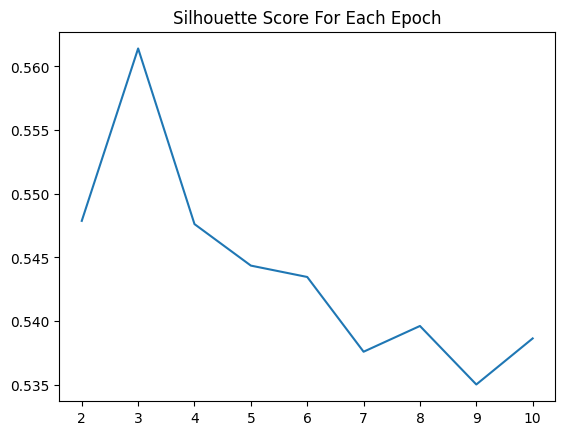

In [21]:
# identify optimal number of epochs
# plot k means silhouette score for each doc2vec epoch
optimise_epochs(tokenized_reviews, 10)

In [22]:
it, model1 = doc2vec(tokenized_reviews, 3) ### Change number of epochs accordingly

### Similarity Matrix

In [23]:
cosine_similarity_matrix(model1)

,https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes,https://www.burpple.com/136-hong-kong-street-fish-head-steamboat-upper-aljunied-road?bp_ref=%2Ff%2FxPFOM3O2,https://www.burpple.com/15-stamford?bp_ref=%2Ff%2FV3JbHfZv,https://www.burpple.com/25-degrees-singapore?bp_ref=%2Ff%2F4bu64FGI,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%2FYd46SA5p,https://www.burpple.com/49-seats-4?bp_ref=%2Ff%2FgMe8caYX,https://www.burpple.com/603-tau-sar-piah?bp_ref=%2Ff%2Foa6NzXzY,https://www.burpple.com/665-degrees-fahrenheit?bp_ref=%2Ff%2FK6qIZ3dx,https://www.burpple.com/726-west-coast-market?bp_ref=%2Ff%2Fw-wo2n5s,https://www.burpple.com/75-ah-balling-peanut-soup?bp_ref=%2Ff%2FJf2IPypA,...,https://www.burpple.com/yogostsg?bp_ref=%2Ff%2FnD1nZVe7,https://www.burpple.com/yong-huat?bp_ref=%2Ff%2Fzr6cmGkf,https://www.burpple.com/yum-cha-2?bp_ref=%2Ff%2Fq-H1rhKl,https://www.burpple.com/yun-nans-2?bp_ref=%2Ff%2Fy14zR297,https://www.burpple.com/yun-nans-nex?bp_ref=%2Ff%2F0dOBBrrw,https://www.burpple.com/yun-nans?bp_ref=%2Ff%2FYmjqWFA7,https://www.burpple.com/zafferano?bp_ref=%2Ff%2Fa86WC8Gr,https://www.burpple.com/zai-shun-curry-fish-head-seafood?bp_ref=%2Ff%2FguifIwH4,https://www.burpple.com/zazz-pizza?bp_ref=%2Ff%2FUx3U197Q,https://www.burpple.com/zoeys-diner?bp_ref=%2Ff%2FAuQ4WK7W
https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes,1.000000,0.999885,0.999967,0.999951,0.999958,0.999914,0.999933,0.999933,0.999840,0.999924,...,0.999967,0.999967,0.999952,0.999949,0.999963,0.999964,0.999966,0.999935,0.999956,0.999958
https://www.burpple.com/136-hong-kong-street-fish-head-steamboat-upper-aljunied-road?bp_ref=%2Ff%2FxPFOM3O2,0.999885,1.000000,0.999921,0.999903,0.999912,0.999861,0.999890,0.999889,0.999796,0.999879,...,0.999918,0.999920,0.999910,0.999903,0.999920,0.999917,0.999916,0.999886,0.999909,0.999911
https://www.burpple.com/15-stamford?bp_ref=%2Ff%2FV3JbHfZv,0.999967,0.999921,1.000000,0.999983,0.999991,0.999939,0.999965,0.999962,0.999870,0.999958,...,0.999996,0.999998,0.999983,0.999980,0.999995,0.999995,0.999995,0.999960,0.999986,0.999989
https://www.burpple.com/25-degrees-singapore?bp_ref=%2Ff%2F4bu64FGI,0.999951,0.999903,0.999983,1.000000,0.999975,0.999925,0.999949,0.999946,0.999859,0.999944,...,0.999981,0.999983,0.999967,0.999962,0.999979,0.999979,0.999980,0.999945,0.999972,0.999975
https://www.burpple.com/46-mittsu?bp_ref=%2Ff%2FYd46SA5p,0.999958,0.999912,0.999991,0.999975,1.000000,0.999934,0.999959,0.999952,0.999866,0.999952,...,0.999990,0.999991,0.999976,0.999974,0.999987,0.999987,0.999987,0.999954,0.999978,0.999982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://www.burpple.com/yun-nans?bp_ref=%2Ff%2FYmjqWFA7,0.999964,0.999917,0.999995,0.999979,0.999987,0.999934,0.999962,0.999958,0.999863,0.999954,...,0.999993,0.999994,0.999980,0.999978,0.999991,1.000000,0.999992,0.999955,0.999982,0.999986
https://www.burpple.com/zafferano?bp_ref=%2Ff%2Fa86WC8Gr,0.999966,0.999916,0.999995,0.999980,0.999987,0.999936,0.999963,0.999958,0.999865,0.999955,...,0.999993,0.999995,0.999981,0.999976,0.999992,0.999992,1.000000,0.999956,0.999982,0.999986
https://www.burpple.com/zai-shun-curry-fish-head-seafood?bp_ref=%2Ff%2FguifIwH4,0.999935,0.999886,0.999960,0.999945,0.999954,0.999905,0.999930,0.999922,0.999831,0.999923,...,0.999959,0.999960,0.999944,0.999942,0.999956,0.999955,0.999956,1.000000,0.999945,0.999950
https://www.burpple.com/zazz-pizza?bp_ref=%2Ff%2FUx3U197Q,0.999956,0.999909,0.999986,0.999972,0.999978,0.999924,0.999954,0.999947,0.999863,0.999944,...,0.999984,0.999986,0.999971,0.999968,0.999982,0.999982,0.999982,0.999945,1.000000,0.999977


### Text Clustering Using K-Means

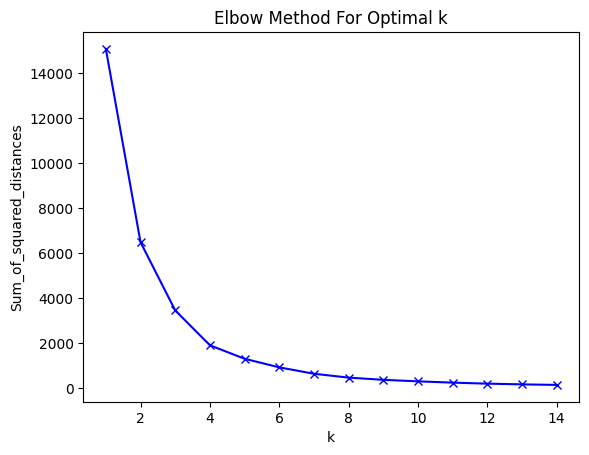

In [24]:
num_topics_elbow(model1)

[0.5644226, 0.57563996, 0.5555966, 0.55467546, 0.5510236, 0.5526412]


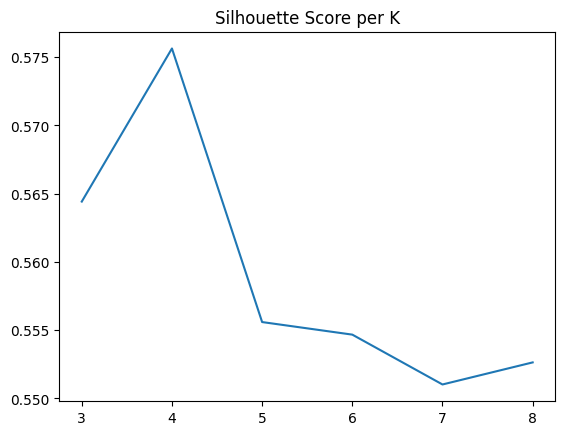

In [25]:
num_topics_silhouette(model1, 3, 8) ### CHANGE ACCORDINGLY

#### Cluster Visualisation

In [26]:
num_clusters = 4 ### CHANGE ACCORDINGLY 
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100) 
X = kmeans.fit(model1.dv.vectors) ### CHANGE MODEL NUMBER
labels = kmeans.labels_.tolist()

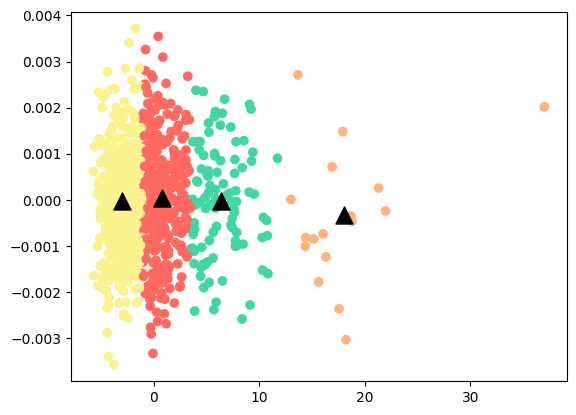

In [27]:
pca_plot(model1)

#### Cluster Interpretation

In [28]:
interpret_df = nearest_restaurants_to_centroid(model1)

2    396
0    337
3     95
1     17
Name: topics, dtype: int64


In [29]:
interpret_df[interpret_df['topics'] == 0]

,topics,url,name,cleaned_text
495,0,https://www.burpple.com/ms-durian?bp_ref=%2Ff%...,Ms Durian,fan durian yes youre treat christmas msdurianp...
279,0,https://www.burpple.com/gok-bbq?bp_ref=%2F%40z...,Go! K-BBQ (Bukit Timah Plaza),steam egg steam egg fluffy wobbly soft beautif...
419,0,https://www.burpple.com/li-bai-cantonese-resta...,Li Bai Cantonese Restaurant,li bai new bird nest lobster yu sheng platter ...
737,0,https://www.burpple.com/the-marmalade-pantry-i...,The Marmalade Pantry (ION Orchard),maccheroni truffle cream blue cheese mozzarell...
567,0,https://www.burpple.com/peony-jade?bp_ref=%2Ff...,Peony Jade,reap abundance wealth royale luxe lobster scal...
260,0,https://www.burpple.com/gaig-restaurant-singap...,Gaig,new seasonal fivecourse chef menu 158 celebrat...
813,0,https://www.burpple.com/woodlands-sourdough?bp...,Woodlands Sourdough,surprisingly affordable fancy pastry white_sma...
669,0,https://www.burpple.com/sukiya-14?bp_ref=%2Ff%...,SUKIYA (Suntec City),gyudon 490 delicious price shopping mall affor...
524,0,https://www.burpple.com/oberstrasse?bp_ref=%2F...,Oberstrasse (Kitchener Complex),conveniently locate near lavender mrt rosti go...
729,0,https://www.burpple.com/the-grumpy-bear-cafe?b...,The Grumpy Bear (Thomson Plaza),fall mint leaf lake spicy popcorn chicken spar...


## Model 2
Appended additional adjective words

In [30]:
def create_adj_tokenized_reviews(n):
    adj_tokenized_reviews = []
    for review in tokenized_reviews:
        adj_tokenized = []
        for token in review:
            adj_tokenized.append(token)
            word, pos = nltk.pos_tag([token])[0]
            if pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos == 'RB' or pos == 'RBR' or pos == 'RBS':
                for i in range(n):
                    adj_tokenized.append(token)
                
        adj_tokenized_reviews.append(adj_tokenized)
    return adj_tokenized_reviews

In [31]:
adj_tokenized_reviews = create_adj_tokenized_reviews(1)

In [32]:
len(adj_tokenized_reviews[0])

1667

In [33]:
len(tokenized_reviews[0])

1390

#### Train Model

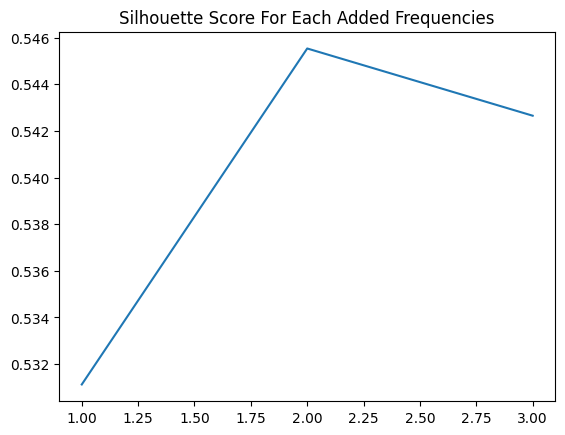

In [34]:
# identify optimal weights. Assume 5 clusters, 10 epochs 
scores = []
range_weights = range(1,4)
for i in range_weights:
    adj_tokenized_reviews = create_adj_tokenized_reviews(i)
    scores.append(plot_silhouette(adj_tokenized_reviews))

plt.plot(list(range_weights),scores)
plt.title('Silhouette Score For Each Added Frequencies')
plt.show()

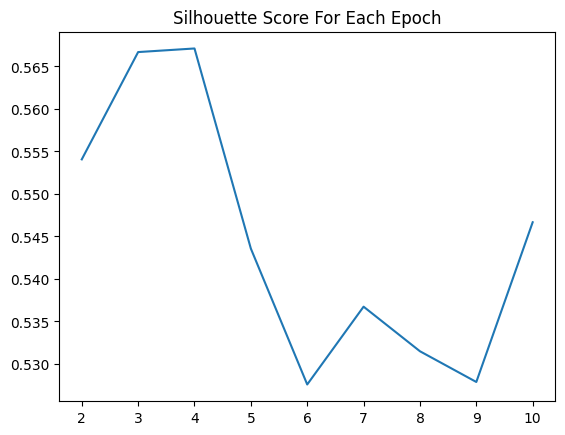

In [35]:
# identify optimal number of epochs
adj_tokenized_reviews = create_adj_tokenized_reviews(2)
optimise_epochs(adj_tokenized_reviews, 10)

In [36]:
it, model2 = doc2vec(adj_tokenized_reviews, 4) ### Change number of epochs accordingly

### Similarity Matrix

In [37]:
cosine_similarity_matrix(model2)

,https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes,https://www.burpple.com/136-hong-kong-street-fish-head-steamboat-upper-aljunied-road?bp_ref=%2Ff%2FxPFOM3O2,https://www.burpple.com/15-stamford?bp_ref=%2Ff%2FV3JbHfZv,https://www.burpple.com/25-degrees-singapore?bp_ref=%2Ff%2F4bu64FGI,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%2FYd46SA5p,https://www.burpple.com/49-seats-4?bp_ref=%2Ff%2FgMe8caYX,https://www.burpple.com/603-tau-sar-piah?bp_ref=%2Ff%2Foa6NzXzY,https://www.burpple.com/665-degrees-fahrenheit?bp_ref=%2Ff%2FK6qIZ3dx,https://www.burpple.com/726-west-coast-market?bp_ref=%2Ff%2Fw-wo2n5s,https://www.burpple.com/75-ah-balling-peanut-soup?bp_ref=%2Ff%2FJf2IPypA,...,https://www.burpple.com/yogostsg?bp_ref=%2Ff%2FnD1nZVe7,https://www.burpple.com/yong-huat?bp_ref=%2Ff%2Fzr6cmGkf,https://www.burpple.com/yum-cha-2?bp_ref=%2Ff%2Fq-H1rhKl,https://www.burpple.com/yun-nans-2?bp_ref=%2Ff%2Fy14zR297,https://www.burpple.com/yun-nans-nex?bp_ref=%2Ff%2F0dOBBrrw,https://www.burpple.com/yun-nans?bp_ref=%2Ff%2FYmjqWFA7,https://www.burpple.com/zafferano?bp_ref=%2Ff%2Fa86WC8Gr,https://www.burpple.com/zai-shun-curry-fish-head-seafood?bp_ref=%2Ff%2FguifIwH4,https://www.burpple.com/zazz-pizza?bp_ref=%2Ff%2FUx3U197Q,https://www.burpple.com/zoeys-diner?bp_ref=%2Ff%2FAuQ4WK7W
https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes,1.000000,0.999909,0.999991,0.999985,0.999985,0.999976,0.999979,0.999968,0.999926,0.999974,...,0.999990,0.999990,0.999980,0.999978,0.999987,0.999988,0.999989,0.999973,0.999983,0.999985
https://www.burpple.com/136-hong-kong-street-fish-head-steamboat-upper-aljunied-road?bp_ref=%2Ff%2FxPFOM3O2,0.999909,1.000000,0.999920,0.999913,0.999915,0.999903,0.999911,0.999901,0.999858,0.999903,...,0.999918,0.999919,0.999913,0.999908,0.999920,0.999917,0.999916,0.999903,0.999913,0.999913
https://www.burpple.com/15-stamford?bp_ref=%2Ff%2FV3JbHfZv,0.999991,0.999920,1.000000,0.999993,0.999994,0.999982,0.999988,0.999976,0.999934,0.999983,...,0.999997,0.999998,0.999988,0.999986,0.999995,0.999996,0.999996,0.999979,0.999991,0.999992
https://www.burpple.com/25-degrees-singapore?bp_ref=%2Ff%2F4bu64FGI,0.999985,0.999913,0.999993,1.000000,0.999988,0.999977,0.999982,0.999970,0.999931,0.999978,...,0.999992,0.999993,0.999982,0.999980,0.999990,0.999990,0.999991,0.999974,0.999986,0.999988
https://www.burpple.com/46-mittsu?bp_ref=%2Ff%2FYd46SA5p,0.999985,0.999915,0.999994,0.999988,1.000000,0.999978,0.999984,0.999970,0.999932,0.999979,...,0.999993,0.999994,0.999983,0.999982,0.999991,0.999991,0.999992,0.999976,0.999986,0.999988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://www.burpple.com/yun-nans?bp_ref=%2Ff%2FYmjqWFA7,0.999988,0.999917,0.999996,0.999990,0.999991,0.999979,0.999985,0.999973,0.999930,0.999980,...,0.999995,0.999995,0.999985,0.999985,0.999992,1.000000,0.999994,0.999976,0.999987,0.999990
https://www.burpple.com/zafferano?bp_ref=%2Ff%2Fa86WC8Gr,0.999989,0.999916,0.999996,0.999991,0.999992,0.999980,0.999986,0.999973,0.999931,0.999981,...,0.999995,0.999996,0.999986,0.999984,0.999993,0.999994,1.000000,0.999977,0.999988,0.999990
https://www.burpple.com/zai-shun-curry-fish-head-seafood?bp_ref=%2Ff%2FguifIwH4,0.999973,0.999903,0.999979,0.999974,0.999976,0.999964,0.999970,0.999956,0.999915,0.999965,...,0.999978,0.999979,0.999968,0.999967,0.999976,0.999976,0.999977,1.000000,0.999970,0.999972
https://www.burpple.com/zazz-pizza?bp_ref=%2Ff%2FUx3U197Q,0.999983,0.999913,0.999991,0.999986,0.999986,0.999973,0.999980,0.999966,0.999929,0.999974,...,0.999989,0.999990,0.999980,0.999979,0.999987,0.999987,0.999988,0.999970,1.000000,0.999985


### Text Clustering Using K-Means

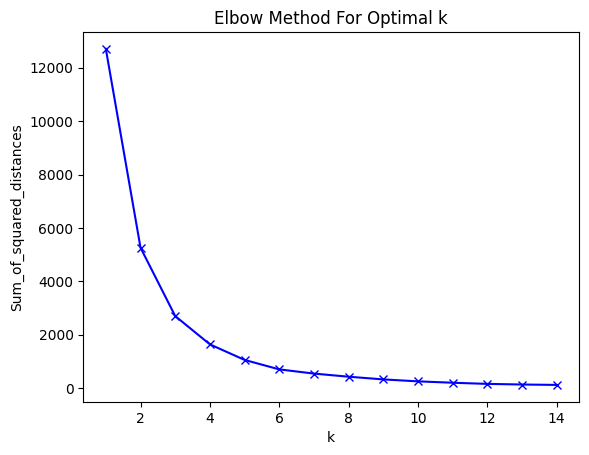

In [38]:
num_topics_elbow(model2)

[0.56565857, 0.5588658, 0.5536583, 0.54755354, 0.53533864, 0.53389317]


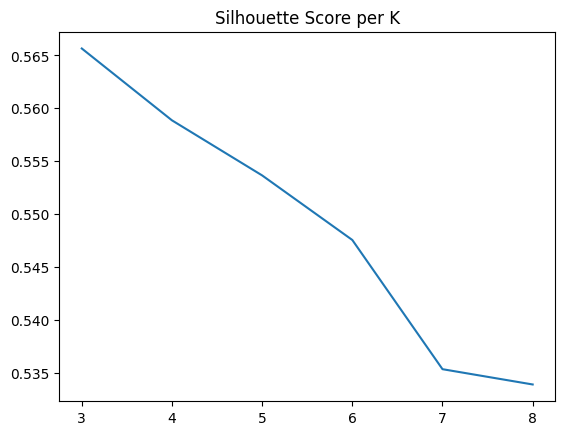

In [39]:
num_topics_silhouette(model2, 3, 8) ### CHANGE ACCORDINGLY

#### Cluster Visualisation

In [41]:
num_clusters = 3 ### CHANGE ACCORDINGLY
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100) 
X = kmeans.fit(model2.dv.vectors) ### CHANGE MODEL NUMBER
labels = kmeans.labels_.tolist()

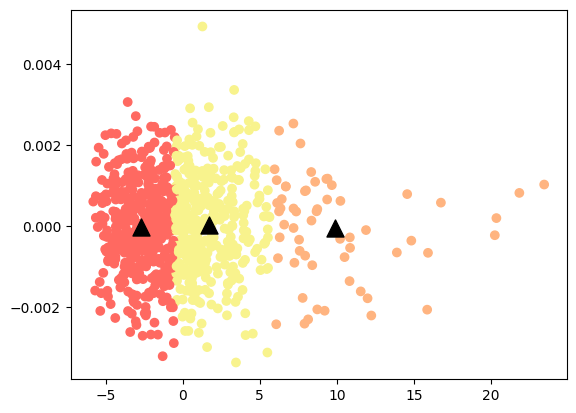

In [42]:
pca_plot(model2)

#### Cluster Interpretation

In [43]:
interpret_df = nearest_restaurants_to_centroid(model2)

0    434
2    352
1     59
Name: topics, dtype: int64


In [44]:
interpret_df[interpret_df['topics'] == 0]

,topics,url,name,cleaned_text
838,0,https://www.burpple.com/yun-nans-2?bp_ref=%2Ff...,Yun Nans (Westgate),yun nan create steam pot chicken soup lily bul...
430,0,https://www.burpple.com/lorong-32-geylang-ban-...,L32 Handmade Noodles (Geylang),handtorn mee hoon kueh toss savoury dark sauce...
837,0,https://www.burpple.com/yum-cha-2?bp_ref=%2Ff%...,Yum Cha (Chinatown Complex),good bad 610 love aromatic serve generous amou...
504,0,https://www.burpple.com/nalan-restaurant?bp_re...,Nalan Restaurant (Capitol Singapore),couldnt rich smokey tikka masala kept smother ...
655,0,https://www.burpple.com/smooy-jem?bp_ref=%2Ff%...,Smöoy (Jem),thanks sweet treat im back enjoy twister fruit...
607,0,https://www.burpple.com/rich-and-good-cake-sho...,Rich & Good Cake Shop (Kandahar),freshly handmade traditional swiss roll rich g...
65,0,https://www.burpple.com/bami-express?bp_ref=%2...,Bami Express (Tanjong Pagar Plaza),bami express small eatery tanjong pagar plaza ...
568,0,https://www.burpple.com/peoples-park-complex-3...,People's Park Complex Food Centre,川味园 chuan wei yuan stall affordable mapo tofu ...
472,0,https://www.burpple.com/miam-miam-westgate?bp_...,Miam Miam (Westgate),choc souffle bad top crust inside fluffy sligh...
775,0,https://www.burpple.com/tsuta-japanese-dining?...,Tsuta Japanese Dining (313@Somerset),broth good crab miso taste super strong noodle...


## Model 3
Bi-gram

In [45]:
from gensim.models.phrases import Phrases, Phraser
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_reviews) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

bigram_reviews = make_bigrams(tokenized_reviews)

#### Train Model

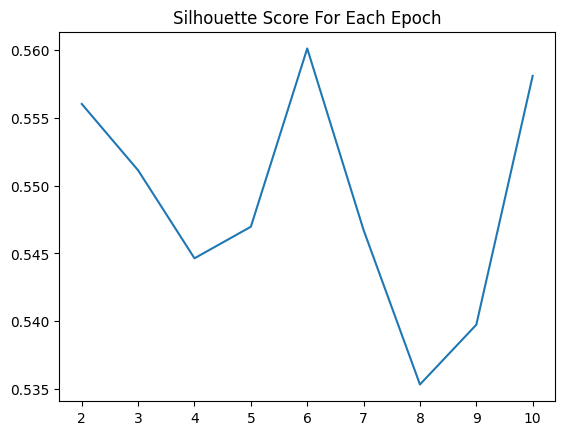

In [50]:
# identify optimal number of epochs
# plot k means silhouette score for each doc2vec epoch
optimise_epochs(bigram_reviews, 10)

In [51]:
it, model3 = doc2vec(bigram_reviews, 6) ### Change number of epochs accordingly

### Similarity Matrix

In [52]:
cosine_similarity_matrix(model3)

,https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes,https://www.burpple.com/136-hong-kong-street-fish-head-steamboat-upper-aljunied-road?bp_ref=%2Ff%2FxPFOM3O2,https://www.burpple.com/15-stamford?bp_ref=%2Ff%2FV3JbHfZv,https://www.burpple.com/25-degrees-singapore?bp_ref=%2Ff%2F4bu64FGI,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%2FYd46SA5p,https://www.burpple.com/49-seats-4?bp_ref=%2Ff%2FgMe8caYX,https://www.burpple.com/603-tau-sar-piah?bp_ref=%2Ff%2Foa6NzXzY,https://www.burpple.com/665-degrees-fahrenheit?bp_ref=%2Ff%2FK6qIZ3dx,https://www.burpple.com/726-west-coast-market?bp_ref=%2Ff%2Fw-wo2n5s,https://www.burpple.com/75-ah-balling-peanut-soup?bp_ref=%2Ff%2FJf2IPypA,...,https://www.burpple.com/yogostsg?bp_ref=%2Ff%2FnD1nZVe7,https://www.burpple.com/yong-huat?bp_ref=%2Ff%2Fzr6cmGkf,https://www.burpple.com/yum-cha-2?bp_ref=%2Ff%2Fq-H1rhKl,https://www.burpple.com/yun-nans-2?bp_ref=%2Ff%2Fy14zR297,https://www.burpple.com/yun-nans-nex?bp_ref=%2Ff%2F0dOBBrrw,https://www.burpple.com/yun-nans?bp_ref=%2Ff%2FYmjqWFA7,https://www.burpple.com/zafferano?bp_ref=%2Ff%2Fa86WC8Gr,https://www.burpple.com/zai-shun-curry-fish-head-seafood?bp_ref=%2Ff%2FguifIwH4,https://www.burpple.com/zazz-pizza?bp_ref=%2Ff%2FUx3U197Q,https://www.burpple.com/zoeys-diner?bp_ref=%2Ff%2FAuQ4WK7W
https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes,1.000000,0.999979,0.999995,0.999992,0.999993,0.999992,0.999990,0.999988,0.999978,0.999990,...,0.999995,0.999995,0.999990,0.999990,0.999993,0.999994,0.999994,0.999991,0.999992,0.999992
https://www.burpple.com/136-hong-kong-street-fish-head-steamboat-upper-aljunied-road?bp_ref=%2Ff%2FxPFOM3O2,0.999979,1.000000,0.999985,0.999981,0.999982,0.999981,0.999980,0.999978,0.999968,0.999979,...,0.999984,0.999984,0.999981,0.999979,0.999984,0.999983,0.999983,0.999980,0.999981,0.999981
https://www.burpple.com/15-stamford?bp_ref=%2Ff%2FV3JbHfZv,0.999995,0.999985,1.000000,0.999997,0.999998,0.999996,0.999995,0.999992,0.999982,0.999995,...,0.999999,0.999999,0.999995,0.999994,0.999997,0.999998,0.999998,0.999994,0.999995,0.999996
https://www.burpple.com/25-degrees-singapore?bp_ref=%2Ff%2F4bu64FGI,0.999992,0.999981,0.999997,1.000000,0.999995,0.999994,0.999992,0.999989,0.999980,0.999992,...,0.999996,0.999996,0.999992,0.999991,0.999995,0.999995,0.999995,0.999992,0.999993,0.999994
https://www.burpple.com/46-mittsu?bp_ref=%2Ff%2FYd46SA5p,0.999993,0.999982,0.999998,0.999995,1.000000,0.999995,0.999993,0.999990,0.999981,0.999993,...,0.999997,0.999997,0.999993,0.999993,0.999996,0.999996,0.999996,0.999993,0.999994,0.999994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://www.burpple.com/yun-nans?bp_ref=%2Ff%2FYmjqWFA7,0.999994,0.999983,0.999998,0.999995,0.999996,0.999994,0.999993,0.999990,0.999980,0.999993,...,0.999997,0.999997,0.999993,0.999993,0.999996,1.000000,0.999996,0.999993,0.999994,0.999995
https://www.burpple.com/zafferano?bp_ref=%2Ff%2Fa86WC8Gr,0.999994,0.999983,0.999998,0.999995,0.999996,0.999995,0.999994,0.999991,0.999981,0.999993,...,0.999997,0.999998,0.999993,0.999992,0.999996,0.999996,1.000000,0.999993,0.999994,0.999995
https://www.burpple.com/zai-shun-curry-fish-head-seafood?bp_ref=%2Ff%2FguifIwH4,0.999991,0.999980,0.999994,0.999992,0.999993,0.999991,0.999990,0.999987,0.999977,0.999990,...,0.999994,0.999994,0.999989,0.999989,0.999992,0.999993,0.999993,1.000000,0.999990,0.999991
https://www.burpple.com/zazz-pizza?bp_ref=%2Ff%2FUx3U197Q,0.999992,0.999981,0.999995,0.999993,0.999994,0.999992,0.999991,0.999988,0.999980,0.999990,...,0.999995,0.999995,0.999991,0.999990,0.999994,0.999994,0.999994,0.999990,1.000000,0.999992


### Text Clustering Using K-Means

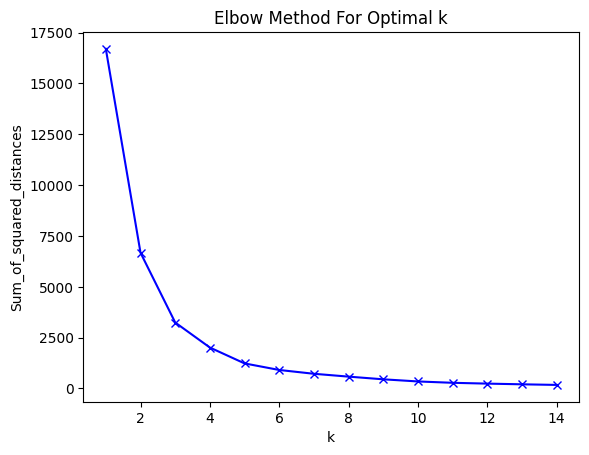

In [53]:
num_topics_elbow(model3)

[0.56354386, 0.55450195, 0.55936885, 0.5457195, 0.5289178, 0.53187937]


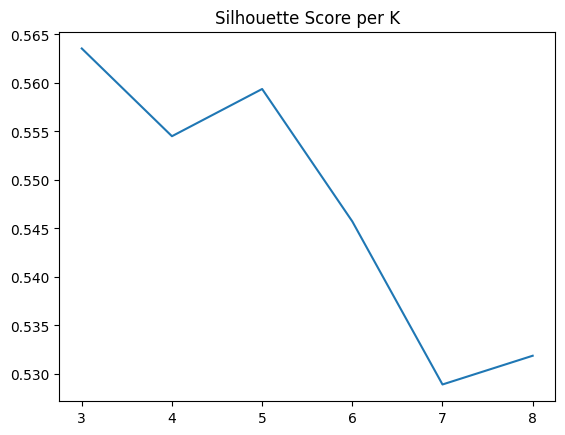

In [54]:
num_topics_silhouette(model3, 3, 8) ### CHANGE ACCORDINGLY

#### Cluster Visualisation

In [55]:
num_clusters = 3 ### CHANGE ACCORDINGLY 
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100) 
X = kmeans.fit(model3.dv.vectors) ### CHANGE MODEL NUMBER
labels = kmeans.labels_.tolist()

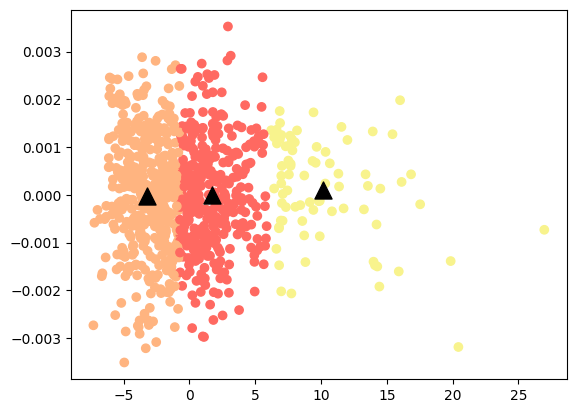

In [56]:
pca_plot(model3)

#### Cluster Interpretation

In [57]:
interpret_df = nearest_restaurants_to_centroid(model3)

1    429
0    338
2     78
Name: topics, dtype: int64


In [58]:
interpret_df[interpret_df['topics'] == 0]

,topics,url,name,cleaned_text
763,0,https://www.burpple.com/tolidos-espresso-nook?...,Tolido's Espresso Nook (Lavender),sweet savoury dish do delight symphony mouth t...
732,0,https://www.burpple.com/the-headless-baker?bp_...,The Headless Baker (Ghim Moh Market),headless bakery found ghim hoh hawker sell ple...
454,0,https://www.burpple.com/master-chippy-cafe-wok...,Master Chippy (Toa Payoh),try master chippy many year fish nicely fry oi...
531,0,https://www.burpple.com/old-hen-coffee-bar?bp_...,Old Hen Coffee Bar,sparklessparklessparklessparkles old hen quain...
541,0,https://www.burpple.com/oneninety-bar-by-javie...,One-Ninety Bar (Four Seasons Hotel Singapore),oneninety bar garden fssingapore serf japanese...
500,0,https://www.burpple.com/muyoo-jurong-point?bp_...,MuYoo+ (Jurong Point),milk bun v sticky surface q soft milky slightl...
718,0,https://www.burpple.com/the-butchers-wife?bp_r...,The Butcher's Wife,butcher wife natural wine bar kitchen dish bra...
584,0,https://www.burpple.com/prawnaholic-sg?bp_ref=...,Prawnaholic (Pasir Ris Central Hawker),signature dry soup version come deshelled praw...
637,0,https://www.burpple.com/shin-minori-japanese-r...,Shin Minori (UE Square),use 11 v worth without wouldnt back expensive ...
113,0,https://www.burpple.com/burger-lobster-raffles...,Burger & Lobster (Raffles Singapore),disappoint serve fry salad chill chunk lobster...


## Model 4
Tri-gram

In [59]:
from gensim.models.phrases import Phrases, Phraser
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_reviews) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram_mod['tokenized_reviews'])
trigram_mod = gensim.models.phrases.Phraser(trigram)


def make_trigrams(texts):
    return [trigram_mod[doc] for doc in texts]

trigram_reviews = make_trigrams(tokenized_reviews)

#### Train Model

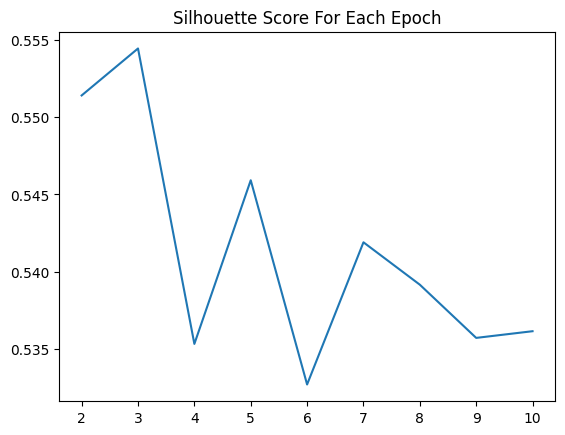

In [60]:
# identify optimal number of epochs
# plot k means silhouette score for each doc2vec epoch
optimise_epochs(trigram_reviews, 10)

In [61]:
it, model4 = doc2vec(trigram_reviews, 3) ### Change number of epochs accordingly

### Similarity Matrix

In [62]:
cosine_similarity_matrix(model4)

,https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes,https://www.burpple.com/136-hong-kong-street-fish-head-steamboat-upper-aljunied-road?bp_ref=%2Ff%2FxPFOM3O2,https://www.burpple.com/15-stamford?bp_ref=%2Ff%2FV3JbHfZv,https://www.burpple.com/25-degrees-singapore?bp_ref=%2Ff%2F4bu64FGI,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%2FYd46SA5p,https://www.burpple.com/49-seats-4?bp_ref=%2Ff%2FgMe8caYX,https://www.burpple.com/603-tau-sar-piah?bp_ref=%2Ff%2Foa6NzXzY,https://www.burpple.com/665-degrees-fahrenheit?bp_ref=%2Ff%2FK6qIZ3dx,https://www.burpple.com/726-west-coast-market?bp_ref=%2Ff%2Fw-wo2n5s,https://www.burpple.com/75-ah-balling-peanut-soup?bp_ref=%2Ff%2FJf2IPypA,...,https://www.burpple.com/yogostsg?bp_ref=%2Ff%2FnD1nZVe7,https://www.burpple.com/yong-huat?bp_ref=%2Ff%2Fzr6cmGkf,https://www.burpple.com/yum-cha-2?bp_ref=%2Ff%2Fq-H1rhKl,https://www.burpple.com/yun-nans-2?bp_ref=%2Ff%2Fy14zR297,https://www.burpple.com/yun-nans-nex?bp_ref=%2Ff%2F0dOBBrrw,https://www.burpple.com/yun-nans?bp_ref=%2Ff%2FYmjqWFA7,https://www.burpple.com/zafferano?bp_ref=%2Ff%2Fa86WC8Gr,https://www.burpple.com/zai-shun-curry-fish-head-seafood?bp_ref=%2Ff%2FguifIwH4,https://www.burpple.com/zazz-pizza?bp_ref=%2Ff%2FUx3U197Q,https://www.burpple.com/zoeys-diner?bp_ref=%2Ff%2FAuQ4WK7W
https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes,1.000000,0.999846,0.999969,0.999956,0.999960,0.999913,0.999942,0.999920,0.999691,0.999924,...,0.999968,0.999968,0.999949,0.999957,0.999964,0.999965,0.999968,0.999920,0.999954,0.999961
https://www.burpple.com/136-hong-kong-street-fish-head-steamboat-upper-aljunied-road?bp_ref=%2Ff%2FxPFOM3O2,0.999846,1.000000,0.999882,0.999867,0.999873,0.999818,0.999858,0.999836,0.999608,0.999837,...,0.999879,0.999881,0.999867,0.999870,0.999881,0.999877,0.999877,0.999832,0.999866,0.999872
https://www.burpple.com/15-stamford?bp_ref=%2Ff%2FV3JbHfZv,0.999969,0.999882,1.000000,0.999987,0.999991,0.999937,0.999972,0.999947,0.999719,0.999956,...,0.999996,0.999998,0.999979,0.999986,0.999994,0.999995,0.999995,0.999942,0.999981,0.999990
https://www.burpple.com/25-degrees-singapore?bp_ref=%2Ff%2F4bu64FGI,0.999956,0.999867,0.999987,1.000000,0.999979,0.999926,0.999960,0.999934,0.999712,0.999946,...,0.999985,0.999986,0.999967,0.999974,0.999982,0.999983,0.999984,0.999931,0.999972,0.999979
https://www.burpple.com/46-mittsu?bp_ref=%2Ff%2FYd46SA5p,0.999960,0.999873,0.999991,0.999979,1.000000,0.999931,0.999967,0.999937,0.999717,0.999951,...,0.999990,0.999991,0.999971,0.999980,0.999987,0.999988,0.999988,0.999938,0.999974,0.999983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://www.burpple.com/yun-nans?bp_ref=%2Ff%2FYmjqWFA7,0.999965,0.999877,0.999995,0.999983,0.999988,0.999931,0.999969,0.999943,0.999710,0.999953,...,0.999993,0.999994,0.999975,0.999984,0.999990,1.000000,0.999992,0.999938,0.999977,0.999987
https://www.burpple.com/zafferano?bp_ref=%2Ff%2Fa86WC8Gr,0.999968,0.999877,0.999995,0.999984,0.999988,0.999933,0.999970,0.999943,0.999714,0.999954,...,0.999994,0.999995,0.999977,0.999983,0.999991,0.999992,1.000000,0.999939,0.999979,0.999987
https://www.burpple.com/zai-shun-curry-fish-head-seafood?bp_ref=%2Ff%2FguifIwH4,0.999920,0.999832,0.999942,0.999931,0.999938,0.999886,0.999920,0.999889,0.999663,0.999905,...,0.999942,0.999942,0.999921,0.999932,0.999938,0.999938,0.999939,1.000000,0.999923,0.999933
https://www.burpple.com/zazz-pizza?bp_ref=%2Ff%2FUx3U197Q,0.999954,0.999866,0.999981,0.999972,0.999974,0.999917,0.999957,0.999927,0.999711,0.999938,...,0.999980,0.999982,0.999962,0.999970,0.999977,0.999977,0.999979,0.999923,1.000000,0.999973


### Text Clustering Using K-Means

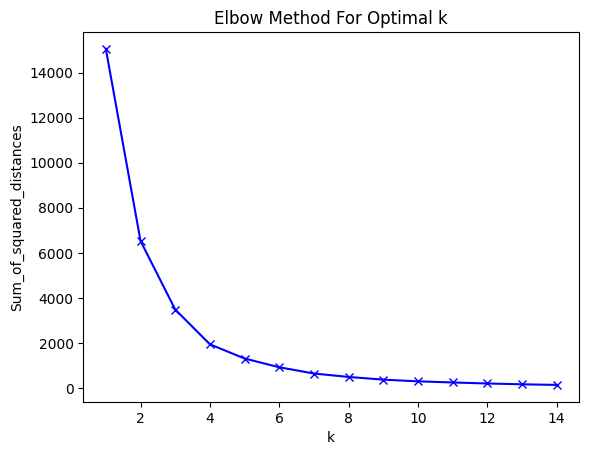

In [63]:
num_topics_elbow(model4)

[0.5608131, 0.5708319, 0.5668202, 0.5682254, 0.5529297, 0.5408971]


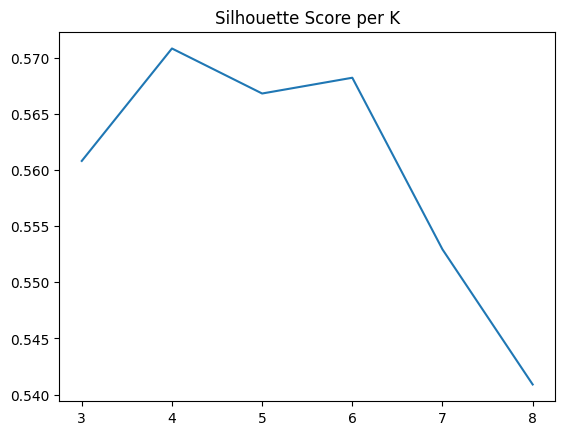

In [64]:
num_topics_silhouette(model4, 3, 8) ### CHANGE ACCORDINGLY

#### Cluster Visualisation

In [65]:
num_clusters = 4 ### CHANGE ACCORDINGLY 
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100) 
X = kmeans.fit(model4.dv.vectors) ### CHANGE MODEL NUMBER
labels = kmeans.labels_.tolist()

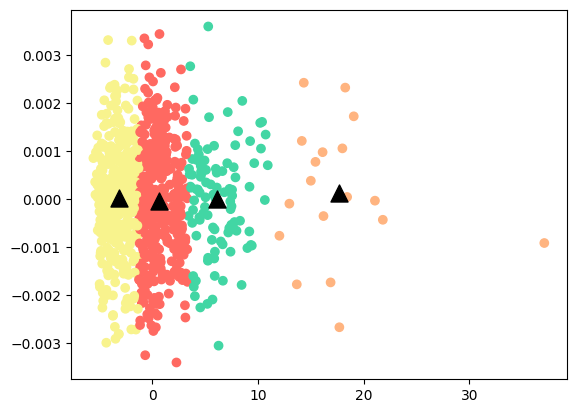

In [66]:
pca_plot(model4)

#### Cluster Interpretation

In [67]:
interpret_df = nearest_restaurants_to_centroid(model4)

2    367
0    362
3     98
1     18
Name: topics, dtype: int64


In [68]:
interpret_df[interpret_df['topics'] == 0]

,topics,url,name,cleaned_text
350,0,https://www.burpple.com/jumbo-ion-orchad?bp_re...,JUMBO Seafood (ION Orchard),mee goreng fry noodle malay style noodle taste...
620,0,https://www.burpple.com/saveur?bp_ref=%2F%40aa...,Saveur (Purvis Street),saveur humble bistro serf hearty honest french...
260,0,https://www.burpple.com/gaig-restaurant-singap...,Gaig,new seasonal fivecourse chef menu 158 celebrat...
718,0,https://www.burpple.com/the-butchers-wife?bp_r...,The Butcher's Wife,butcher wife natural wine bar kitchen dish bra...
37,0,https://www.burpple.com/alice-boulangerie?bp_r...,Alice Boulangerie (Icon Village),fan beef cow miss steak shack 35 feature heart...
401,0,https://www.burpple.com/la-scala-ristorante?bp...,La Scala Ristorante (Capitol Singapore),good highly recommend love pasta al dente youl...
560,0,https://www.burpple.com/paul-4?bp_ref=%2F%4019...,PAUL (Takashimaya),celebrate sweet moment love valentine day paul...
41,0,https://www.burpple.com/amazing-hoki?bp_ref=%2...,Amazing Hoki,cheese green tea nice mix sweet salty gripe to...
326,0,https://www.burpple.com/ippudo-19?bp_ref=%2Ff%...,IPPUDO (Raffles City),karaka take ippudos original smooth creamy por...
763,0,https://www.burpple.com/tolidos-espresso-nook?...,Tolido's Espresso Nook (Lavender),sweet savoury dish do delight symphony mouth t...


## One Hot Encode

In [ ]:
restaurant_review_df_encoded = restaurant_review_df.drop(['name', 'cleaned_text', 'price', 'categories', 'review', 'user', 'date', 'cleaned_categories'], axis=1)

In [ ]:
# one hot encode region & topics
region_dummies = pd.get_dummies(restaurant_review_df_encoded['region'])
neighbourhood_dummies = pd.get_dummies(restaurant_review_df_encoded['neighbourhood'])
topic_dummies = pd.get_dummies(restaurant_review_df_encoded['topics'])

restaurant_review_df_encoded = restaurant_review_df_encoded.drop(['region', 'neighbourhood', 'topics'], axis=1)
restaurant_review_df_encoded = restaurant_review_df_encoded.join(region_dummies)
restaurant_review_df_encoded = restaurant_review_df_encoded.join(neighbourhood_dummies)
restaurant_review_df_encoded = restaurant_review_df_encoded.join(topic_dummies)

In [ ]:
restaurant_review_df_encoded.head(5)

In [ ]:
restaurant_review_df_encoded.to_csv('doc2vec_labelled_restaurants_bigram.csv')

## WordCloud

In [ ]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# concatenate all the reviews for each topic
topic_df = interpret_df[['topics', 'cleaned_text']]
topic_df = topic_df.groupby(['topics'], as_index = False).agg({'cleaned_text': ' '.join})
topic_df

In [ ]:
# TF-IDF
text = topic_df['cleaned_text']
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(text)
feature_names = vectorizer.get_feature_names_out()
dense = X.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names).transpose()
df.columns = topic_df['topics']

In [ ]:
wordcloud = WordCloud(background_color = 'white', collocations = False).generate_from_text(text[0])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white', collocations = False).generate_from_frequencies(df[0])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white', collocations = False).generate_from_text(text[1])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white', collocations = False).generate_from_frequencies(df[1])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white', collocations = False).generate_from_frequencies(df[2])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white', collocations = False).generate_from_frequencies(df[3])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white', collocations = False).generate_from_frequencies(df[4])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white', collocations = False).generate_from_frequencies(df[5])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()